In [ ]:
import geopandas as gpd
import rasterio
import yaml
from utils.hazards import (
    load_config, harmonize_crs, extract_flood_values_to_points,
    check_line_exposure, plot_exposure_map
)
config = load_config("config.yml")
country = gpd.read_file(config["country_shapefile"])
points = gpd.read_file(config["power_points_shapefile"])
lines = gpd.read_file(config["power_lines_shapefile"])
raster = rasterio.open(config["flood_raster"])
points, lines = harmonize_crs([points, lines], country.crs)
points = extract_flood_values_to_points(points, raster, config["flood_threshold"])
lines["exposed"] = lines["geometry"].apply(
    lambda geom: check_line_exposure(
        geom, raster, config["sample_points_per_line"], config["flood_threshold"]
    )
)

In [ ]:
import geopandas as gpd
import rasterio
import yaml
# Load config
config = load_config("config.yml")

# Load spatial data
country = gpd.read_file(config["country_shapefile"])
points = gpd.read_file(config["power_points_shapefile"])
lines = gpd.read_file(config["power_lines_shapefile"])
points, lines = harmonize_crs([points, lines], country.crs)

# Loop over active hazards
for hazard_name, hazard_conf in config["hazards"].items():
    if not hazard_conf.get("active", False):
        print(f"Skipping hazard {hazard_name} (not active)")
        continue

    print(f"\n--- Processing hazard: {hazard_name} ---")

    raster = rasterio.open(hazard_conf["raster"])
    threshold = hazard_conf["threshold"]

    # Points
    points_hazard = extract_flood_values_to_points(points, raster, threshold)
    points_out = f"{config['output_dir']}/points_exposure_{hazard_name.lower()}.shp"
    points_hazard.to_file(points_out)

    # Lines
    lines_hazard = lines.copy()
    lines_hazard["exposed"] = lines_hazard["geometry"].apply(
        lambda geom: check_line_exposure(
            geom, raster, config["sample_points_per_line"], threshold
        )
    )
    lines_out = f"{config['output_dir']}/lines_exposure_{hazard_name.lower()}.shp"
    lines_hazard.to_file(lines_out)

    # Optional: plot
    plot_exposure_map(country, points_hazard, lines_hazard)

Skipping hazard FLOOD (not active)

--- Processing hazard: LANDSLIDE ---
data/landslide.tif already in WGS84.


/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:358: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = get_writer_for_path(path, driver=driver)(
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


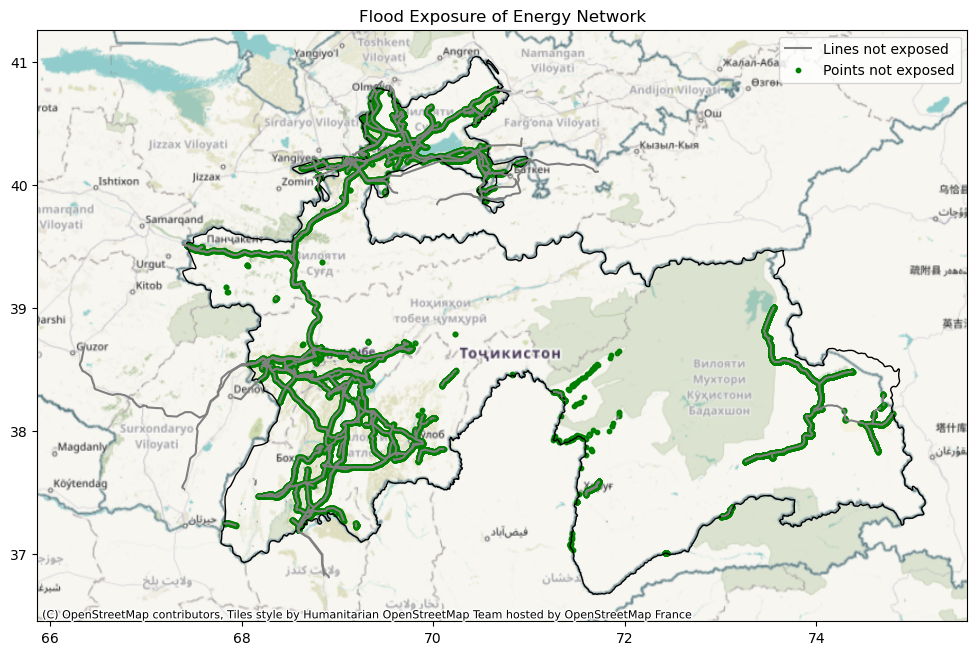

Skipping hazard FIRE (not active)


In [1]:
import geopandas as gpd
import rasterio
import yaml
from utils.hazards import (
    load_config, harmonize_crs, extract_flood_values_to_points,
    check_line_exposure, plot_exposure_map,assign_or_reproject_to_wgs84
)
# Load config
config = load_config("config.yml")

# Load spatial data
aoi = gpd.read_file(config["aoi_shapefile"])
aoi_union = aoi.union_all()
points = gpd.read_file(config["power_points_shapefile"])
lines = gpd.read_file(config["power_lines_shapefile"])
points, lines = harmonize_crs([points, lines], aoi.crs)
# Filter to keep only geometries within aoi boundaries
points = points[points.geometry.within(aoi_union)]
lines = lines[lines.geometry.intersects(aoi_union)]

# Loop over active hazards
for hazard_name, hazard_conf in config["hazards"].items():
    if not hazard_conf.get("active", False):
        print(f"Skipping hazard {hazard_name} (not active)")
        continue

    print(f"\n--- Processing hazard: {hazard_name} ---")
    # Apply CRS check and reprojection
    raster_path_wgs84 = assign_or_reproject_to_wgs84(hazard_conf["raster"])
    raster = rasterio.open(raster_path_wgs84)
    threshold = hazard_conf["threshold"]

    # Points
    points_hazard = extract_flood_values_to_points(points, raster, threshold)
    points_out = f"{config['output_dir']}/points_exposure_{hazard_name.lower()}.shp"
    # Rename the attribut regarding the shp constraint
    points_hazard = points_hazard.rename(columns={
    "flood_value": "fld_value",
    "exposed": "exposed" 
})
    points_hazard.to_file(points_out)

    # Lines
    lines_hazard = lines.copy()
    lines_hazard["exposed"] = lines_hazard["geometry"].apply(
        lambda geom: check_line_exposure(
            geom, raster, config["sample_points_per_line"], threshold
        )
    )
    lines_out = f"{config['output_dir']}/lines_exposure_{hazard_name.lower()}.shp"
    lines_hazard.to_file(lines_out)

    # Optional: plot
    plot_exposure_map(aoi, points_hazard, lines_hazard)